# Worked Examples
This notebook provides some examples of input compounds and the derived scaffold found to be highest-scoring in the DB, alongside explanations of these scores via details on the scaffold's associated compounds, substances and assays from PubChem.

## Background

### PubChem
PubChem (https://pubchem.ncbi.nlm.nih.gov/) is a public chemistry database maintained by the NIH. PubChem includes records for over 100 million compounds and data from over 1 million assays. 


For more information about PubChem see: https://pubchem.ncbi.nlm.nih.gov/docs/about

#### BioAssays
See: https://pubchem.ncbi.nlm.nih.gov/docs/bioassays

#### Substances
See: https://pubchem.ncbi.nlm.nih.gov/docs/substances 

#### Compounds
See: https://pubchem.ncbi.nlm.nih.gov/docs/compounds 

### Badapple (bioassay-data associative promiscuity pattern learning engine)
Badapple is a statistical method for identifying likely promiscuous compounds via their associated scaffolds, using data gathered from PubChem.

For more information see the original Badapple paper: https://jcheminf.biomedcentral.com/articles/10.1186/s13321-016-0137-3

## Setup

In [228]:
BASE_URL = "http://localhost:8000/api/v1"

In [229]:
# imports
import requests
from rdkit import Chem
import pandas as pd

In [230]:
def get_request_data(request_url: str):
    result = requests.get(request_url)
    res = {}
    if result.status_code == 200:
        res = result.json()
    else:
        print(result)
    return res

In [231]:
def get_mol_scaffolds(mol_smiles: str):
    request_url = f"{BASE_URL}/compound_search/get_associated_scaffolds?SMILES={mol_smiles}"
    return get_request_data(request_url)

In [232]:
def get_associated_pubchem_compounds(scafid: int):
    request_url = f"{BASE_URL}/scaffold_search/get_associated_compounds?scafid={scafid}"
    return get_request_data(request_url)

In [233]:
def get_scaf_legend(scaf_info: dict):
    s = f"SMILES: {scaf_info['scafsmi']}\n"
    s+= f"in_db: {scaf_info["in_db"]}"
    if scaf_info["in_db"]:
        s += f" | pscore {scaf_info["pscore"]} | ID: {scaf_info["id"]}"
    return s

In [234]:
def get_mol_scaf_grid(mol_smiles: str, scaf_info_list: list[dict]):
    # process mol
    mol_legend = f"Molecule SMILES = {mol_smiles}"
    mol = Chem.MolFromSmiles(mol_smiles)

    # process scafs
    scaf_mols = [Chem.MolFromSmiles(d['scafsmi']) for d in scaf_info_list]
    scaf_legends = [get_scaf_legend(d) for d in scaf_info_list]

    # combine and draw
    mol_matrix = [[mol]] + [[scaf] for scaf in scaf_mols]
    legend_matrix = [[mol_legend]] + [[legend] for legend in scaf_legends]
    return Chem.Draw.MolsMatrixToGridImage(molsMatrix=mol_matrix, legendsMatrix=legend_matrix, useSVG=True, subImgSize=(600, 300))

In [235]:
def get_mols_grid(mol_smiles_list: list[str], legends: list, mols_per_row: int):
    mols = [Chem.MolFromSmiles(smi) for smi in mol_smiles_list]
    img = Chem.Draw.MolsToGridImage(mols=mols, legends=legends, molsPerRow=mols_per_row, useSVG=True, subImgSize=(300, 300))
    return img

## Load data

In [236]:
tsv_path = "/home/jack/unm_gra/tmp/dtra/vendor_compounds_scores.tsv"
df = pd.read_csv(tsv_path, sep="\t")

In [237]:
# molecule which contains scaffold w/ largest pscore
highest_pscore_mol_row = df.iloc[df["pscore"].argmax()]
highest_pscore_mol_smiles = highest_pscore_mol_row["SMILES"]
highest_pscore_mol_row

IDNUMBER                                            C620-0100
SMILES      CN(C)c1cc(NCCN2CCC3(CC2)OCCO3)c2c3c(onc13)-c1c...
pscore                                                2084.88
scafsmi                           O=C1c2ccccc2-c2onc3cccc1c23
scafid                                                20712.0
Name: 19858, dtype: object

## Visualize Molecule + all of its scaffolds

In [238]:
mol_scaffolds = get_mol_scaffolds(highest_pscore_mol_smiles)
# API returns dict mapping input SMILES to their list of scaffolds
mol_scaffolds = mol_scaffolds[highest_pscore_mol_smiles]

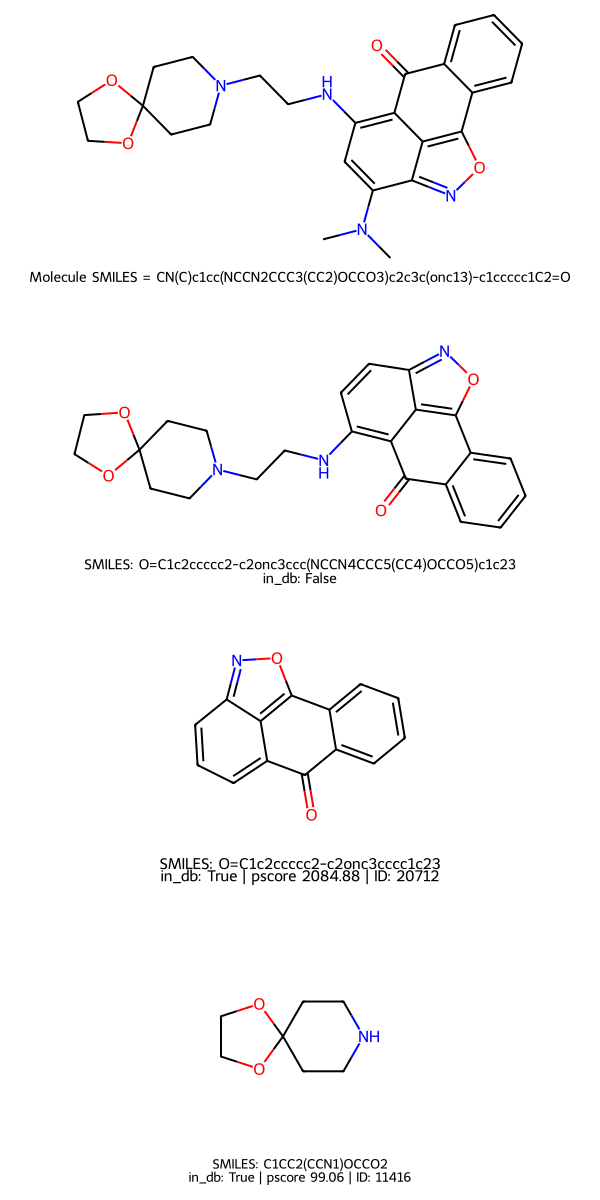

In [239]:
get_mol_scaf_grid(highest_pscore_mol_smiles, mol_scaffolds)

## Analysis of highest-scoring scaffold
The sections below dive into why the scaffold with SMILES `O=C1c2ccccc2-c2onc3cccc1c23` has been assigned the score that it has. In particular, we look at the associated PubChem compounds, substances, and assays that were found to be linked to this scaffold in the Badapple DB. 

In addition, there has been literature published about this particular scaffold, as identified in the original Badapple paper: "Scaffold a 6H-anthra[1,9-cd]isoxazol-6-one is known to react with DMSO acting as a nucleophile and undergoes N–O cleavage of the isoxazole ring to form the ring opened anthraquinone, a species known to form covalent adducts" (https://jcheminf.biomedcentral.com/articles/10.1186/s13321-016-0137-3/tables/7)

### Compounds

In [240]:
scafid = int(highest_pscore_mol_row["scafid"])
associated_compounds = get_associated_pubchem_compounds(scafid)

In [241]:
associated_compounds_df = pd.DataFrame(associated_compounds)

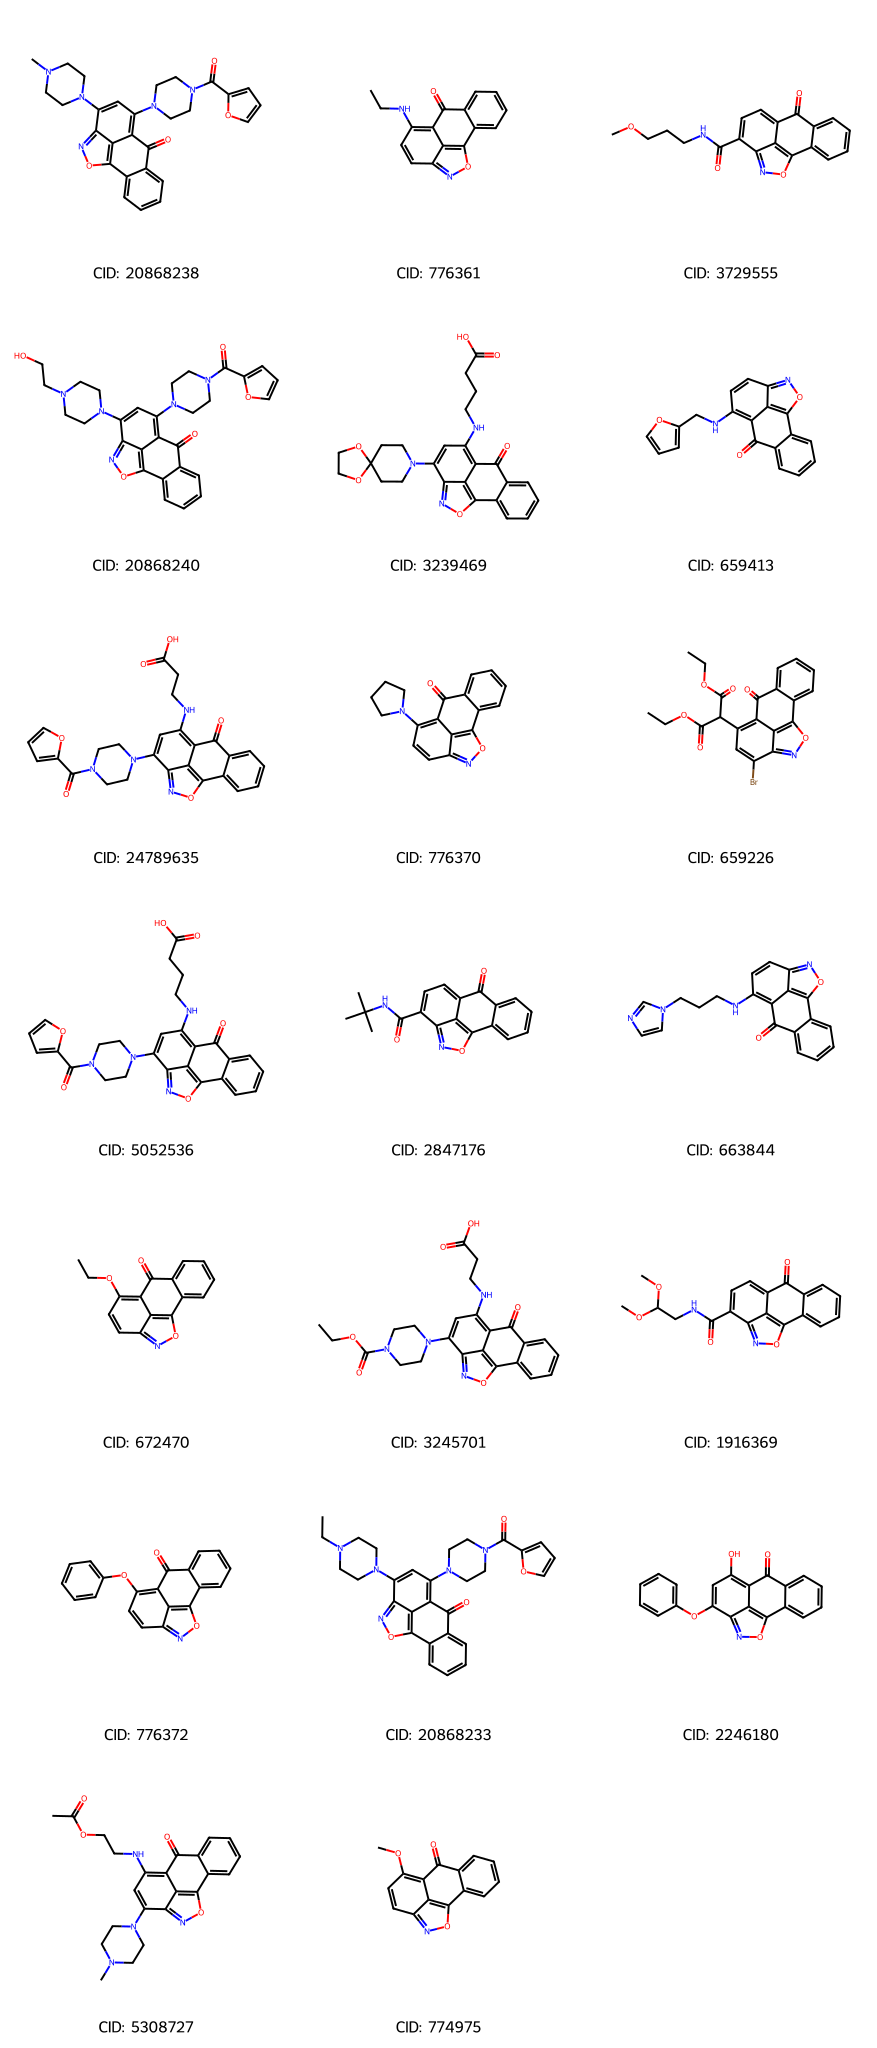

In [242]:
associated_compound_smiles = associated_compounds_df["isosmi"].tolist()
legends = [f"CID: {cid}" for cid in associated_compounds_df["cid"]]
get_mols_grid(associated_compound_smiles, legends, 3)

In [243]:
associated_compounds_df

,cansmi,cid,isosmi,nass_active,nass_tested,nsam_active,nsam_tested,nsub_active,nsub_tested,nsub_total
0,CN1CCN(c2cc(N3CCN(C(=O)c4ccco4)CC3)c3c4c(onc24...,20868238,CN1CCN(CC1)C2=CC(=C3C4=C(C5=CC=CC=C5C3=O)ON=C2...,26,427,26,428,1,1,1
1,CCNc1ccc2noc3c2c1C(=O)c1ccccc1-3,776361,CCNC1=C2C3=C(C4=CC=CC=C4C2=O)ON=C3C=C1,103,650,103,651,1,1,1
2,COCCCNC(=O)c1ccc2c3c(onc13)-c1ccccc1C2=O,3729555,COCCCNC(=O)C1=CC=C2C3=C(C4=CC=CC=C4C2=O)ON=C13,55,495,55,496,1,1,1
3,O=C1c2ccccc2-c2onc3c(N4CCN(CCO)CC4)cc(N4CCN(C(...,20868240,C1CN(CCN1CCO)C2=CC(=C3C4=C(C5=CC=CC=C5C3=O)ON=...,38,482,38,483,1,2,2
4,O=C(O)CCCNc1cc(N2CCC3(CC2)OCCO3)c2noc3c2c1C(=O...,3239469,C1CN(CCC12OCCO2)C3=CC(=C4C5=C(C6=CC=CC=C6C4=O)...,54,471,54,472,1,1,1
5,O=C1c2ccccc2-c2onc3ccc(NCc4ccco4)c1c23,659413,C1=CC=C2C(=C1)C3=C4C(=NO3)C=CC(=C4C2=O)NCC5=CC...,104,675,104,676,1,1,1
6,O=C(O)CCNc1cc(N2CCN(C(=O)c3ccco3)CC2)c2noc3c2c...,24789635,C1CN(CCN1C2=CC(=C3C4=C(C5=CC=CC=C5C3=O)ON=C24)...,61,487,61,488,1,1,1
7,O=C1c2ccccc2-c2onc3ccc(N4CCCC4)c1c23,776370,C1CCN(C1)C2=C3C4=C(C5=CC=CC=C5C3=O)ON=C4C=C2,64,526,64,527,1,1,1
8,CCOC(=O)C(C(=O)OCC)c1cc(Br)c2noc3c2c1C(=O)c1cc...,659226,CCOC(=O)C(C1=C2C3=C(C4=CC=CC=C4C2=O)ON=C3C(=C1...,117,739,117,740,2,2,2
9,O=C(O)CCCNc1cc(N2CCN(C(=O)c3ccco3)CC2)c2noc3c2...,5052536,C1CN(CCN1C2=CC(=C3C4=C(C5=CC=CC=C5C3=O)ON=C24)...,52,488,52,489,1,1,1


### Substances
In PubChem, a given compound can be associated with 1+ substances. The code below pulls the substance IDs (SID) associated with each compound, and provides URL links to each substance with additional information about each of these substances.